# Unsupervised Algorithms: K-Means, PCA

In [1]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_iris

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [7]:
# Load dataset
iris = load_iris()
X, y = iris.data, iris.target  # Real labels are going to be ignored

# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Generate dataframe to visualize data
iris_df = pd.DataFrame(X_train, columns = iris.feature_names)
iris_df['target'] = y_train # Added original target to the dataframe
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,4.6,3.6,1.0,0.2,0
1,5.7,4.4,1.5,0.4,0
2,6.7,3.1,4.4,1.4,1
3,4.8,3.4,1.6,0.2,0
4,4.4,3.2,1.3,0.2,0
...,...,...,...,...,...
115,6.1,2.8,4.0,1.3,1
116,4.9,2.5,4.5,1.7,2
117,5.8,4.0,1.2,0.2,0
118,5.8,2.6,4.0,1.2,1


In [3]:
# Pipeline to generate labels with KMeans and use them as target
class KMeansLabeler(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters = 3):
        self.n_clusters = n_clusters

    def fit(self, X_train, y = None):
        self.kmeans = KMeans(n_clusters = self.n_clusters, random_state = 42)
        self.kmeans.fit(X_train)
        return self

    def transform(self, X_train, y = None):
        return self.kmeans.predict(X_train).reshape(-1, 1)

# Preprocessing transformations
preprocessor = ColumnTransformer(
    transformers = [
        ('scaler', StandardScaler(), slice(0, X_train.shape[1])),  # Scale all columns
        ('pca', PCA(), slice(0, X_train.shape[1]))  # PCA with no n_components (will be optimized later)
    ],
    remainder = 'passthrough'
)

# Pipeline creation
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('clustering', KMeansLabeler(n_clusters = 3)),  # Generate labels with clustering
    ('classifier', RandomForestClassifier(random_state = 42))
])

In [ ]:
# Original generated labels
y_generated_original = KMeans(n_clusters = 3, random_state = 42).fit_predict(X_train)

# Align generated labels with original target to interpret Confusion Matrix correctly
def align_labels(arr):
    x = 0
    if arr == 0:
        x = 2
    elif arr == 1:
        x = 0
    else:
        x = 1
    return x
    
updated_labels = np.vectorize(align_labels)
y_generated = updated_labels(y_generated_original)

# Hyperparameter optimization
param_grid = {
    'preprocessing__pca__n_components': [2, 3],
    'classifier__n_estimators': [25, 50, 100, 150],
    'classifier__max_depth': [5, 10, 20, 30, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__bootstrap': [True, False]
}

grid_search = GridSearchCV(pipeline, param_grid, cv = 5, scoring = 'accuracy', n_jobs = -1)
grid_search.fit(X_train, y_generated)

In [ ]:
# Hyperparameter optimization
param_grid = {
    'preprocessing__pca__n_components': [2, 3],
    'classifier__n_estimators': [25, 50, 100, 150],
    'classifier__max_depth': [5, 10, 20, 30, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__bootstrap': [True, False]
}

grid_search = GridSearchCV(pipeline, param_grid, cv = 5, scoring = 'accuracy', n_jobs = -1)
grid_search.fit(X_train, y_generated)

# Best estimator results
print('Best Cross-Validation Score:', grid_search.best_score_)
print('Best Parameters:', grid_search.best_params_)

# Evaluation
best_model = grid_search.best_estimator_
y_pred_train = best_model.predict(X_train)
print('\nClassification Report for Best Model:\n', classification_report(y_generated, y_pred_train))

Best Cross-Validation Score: 0.8166666666666667
Best Parameters: {'classifier__bootstrap': True, 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 25, 'preprocessing__pca__n_components': 2}

Classification Report for Best Model:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      0.58      0.73        50
           2       0.59      1.00      0.74        30

    accuracy                           0.82       120
   macro avg       0.86      0.86      0.82       120
weighted avg       0.90      0.82      0.82       120



In [8]:
iris_df['generated_labels'] = y_generated
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,generated_labels
0,4.6,3.6,1.0,0.2,0,0
1,5.7,4.4,1.5,0.4,0,0
2,6.7,3.1,4.4,1.4,1,1
3,4.8,3.4,1.6,0.2,0,0
4,4.4,3.2,1.3,0.2,0,0
...,...,...,...,...,...,...
115,6.1,2.8,4.0,1.3,1,2
116,4.9,2.5,4.5,1.7,2,2
117,5.8,4.0,1.2,0.2,0,0
118,5.8,2.6,4.0,1.2,1,2


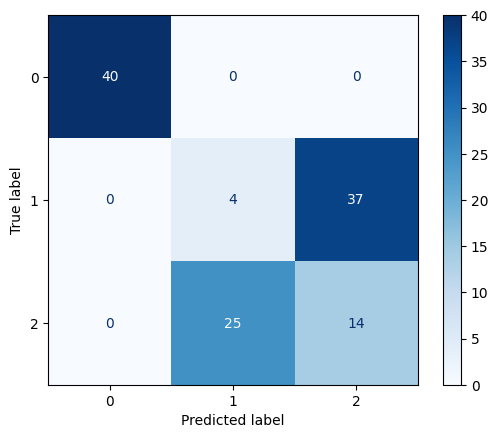

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train, cmap = 'Blues');

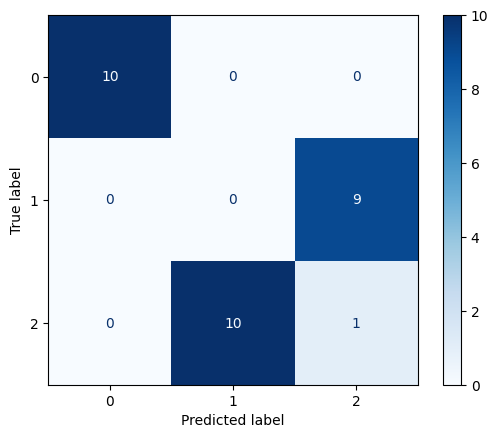

In [12]:
y_pred_test = best_model.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, cmap = 'Blues');

In [ ]:
test_df = pd.DataFrame(X_test, columns = iris.feature_names)
test_df['target'] = y_test

sns.pairplot(test_df, hue = 'generated_labels', palette = 'Paired');

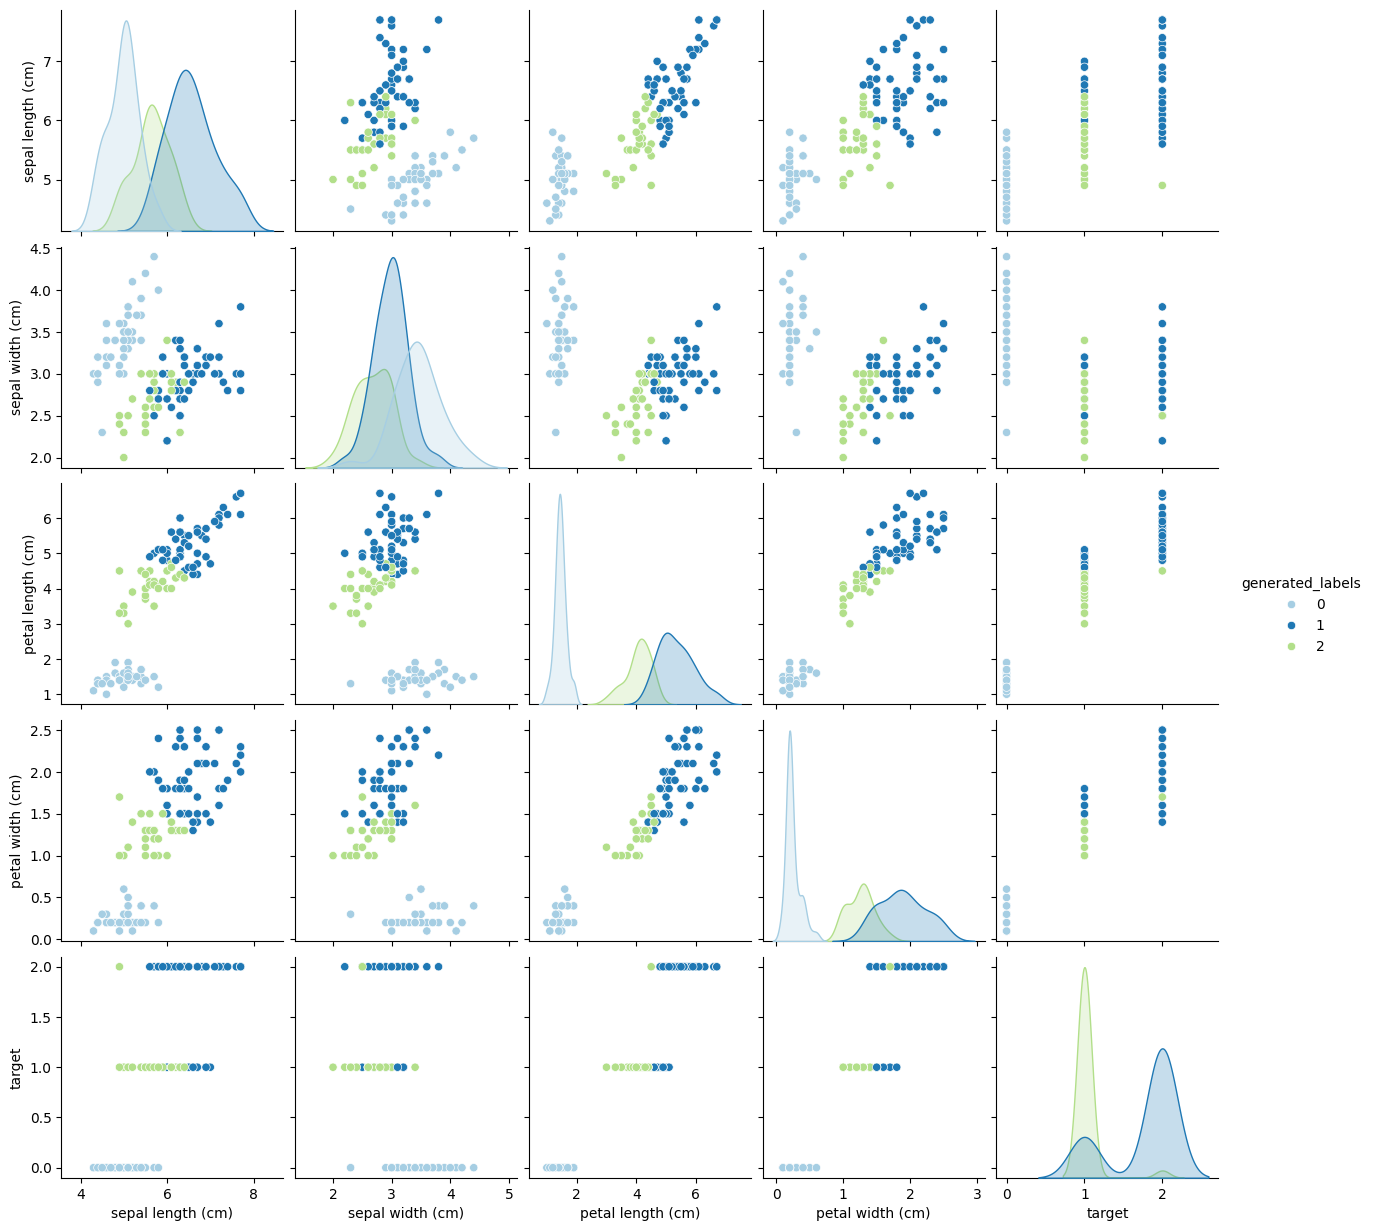

In [11]:
sns.pairplot(iris_df, hue = 'generated_labels', palette = 'Paired');